# IBM Data Science Capstone Project 

# Comparing Diversity of Restaurants in Toronto and NYC

Toronto and New York are incredibly large and diverse cities, having many old and new generations of immigrants, we can expect both multicultural cities to show a wide diversity of restaurants. This notebook will retrieve as many existing restaurants as possible from both cities with FOURSQUARE's Places API. We will also visualize the different types of restaurants to compare and find the similarities and differences with both cities,

In [1]:
import pandas as pd
import numpy as np 
import folium 
import requests
import geocoder
import foursquare

import matplotlib as mpl
import matplotlib.pyplot as plt

from pandas.io.json import json_normalize

In [2]:
from pandas.io.json import json_normalize

In [3]:
# FOURSQUARE Credentials

id_ = 'REMOVED FOR GITHUB'
secret = 'REMOVED FOR GITHUB'
version = '20192505'

client = foursquare.Foursquare(client_id = id_, client_secret = secret, version = version)


### Using FOURSQUARE for searching restaurants

We can retrieve restaurants with FOURSQUARE by giving the API a location, the area of search, as well as the appropriate venue query which in this case will be simply 'restaurant'. Below is an example of the restuarants found around a random location in Toronto 

In [4]:
lat = 43.6533 # Toronto lat, lng
lng = -79.3834


radius = 500 
query = 'restaurant'


search_toronto_raw = client.venues.search(params={'ll': '{},{}'.format(lat,lng), 'radius':radius, 'query':query})['venues'] #45.292127, -75.732131
dataframe_toronto = json_normalize(search_toronto_raw)
dataframe_toronto.head(10)

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",False,4ad4c05ff964a52048f720e3,110 Chestnut Street,CA,Toronto,Canada,NaN,269,"[110 Chestnut Street, Toronto ON M5G 1R3, Canada]","[{'label': 'display', 'lat': 43.65488413420439...",43.654884,-79.385931,NaN,M5G 1R3,ON,Hemispheres Restaurant & Bistro,v-1559212045,NaN
1,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",False,4b295e10f964a520ba9d24e3,14 Queen St W,CA,Toronto,Canada,NaN,266,"[14 Queen St W, Toronto ON M5H 3X4, Canada]","[{'label': 'display', 'lat': 43.65261436174172...",43.652614,-79.380231,NaN,M5H 3X4,ON,Richtree Natural Market Restaurants,v-1559212045,NaN
2,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",False,50ca02c0245f2d4aa8c2b313,145 Richmond Street West,CA,Toronto,Canada,Hilton Toronto,407,"[145 Richmond Street West (Hilton Toronto), To...","[{'label': 'display', 'lat': 43.65000998764964...",43.650010,-79.385608,NaN,M5H 2L2,ON,Tundra Restaurant,v-1559212045,NaN
3,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",False,4b2027b5f964a520f82d24e3,195 Dundas St W,CA,Toronto,Canada,at University Ave,347,"[195 Dundas St W (at University Ave), Toronto ...","[{'label': 'display', 'lat': 43.65492521335936...",43.654925,-79.387089,NaN,M5G 1C7,ON,Hong Shing Chinese Restaurant,v-1559212045,60327598
4,"[{'id': '4bf58dd8d48988d147941735', 'name': 'D...",False,4ad7929cf964a520500c21e3,249 Victoria Street,CA,Toronto,Canada,btwn Dundas St E and Shuter St,427,[249 Victoria Street (btwn Dundas St E and Shu...,"[{'label': 'display', 'lat': 43.65564091455335...",43.655641,-79.379199,NaN,M5B 1T8,ON,The Senator Restaurant,v-1559212045,55585058
5,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",False,5a8b24b2018cbb6c4ca70dae,Yonge And Queen,CA,Toronto,Canada,NaN,298,"[Yonge And Queen, Toronto ON M5G 2H6, Canada]","[{'label': 'display', 'lat': 43.65341542752959...",43.653415,-79.379698,NaN,M5G 2H6,ON,Hendricks Restaurant & Bar,v-1559212045,NaN
6,"[{'id': '4bf58dd8d48988d10f941735', 'name': 'I...",False,5834c90e110d032f3217f899,67 Richmond Street West,CA,Toronto,Canada,Richmond and Bay Street,276,[67 Richmond Street West (Richmond and Bay Str...,"[{'label': 'display', 'lat': 43.65109052088520...",43.651091,-79.381843,NaN,M5H 1Z5,ON,Maezo Restaurant & Bar,v-1559212045,369067217
7,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",False,5a7c3e079de23b294a2c4117,325 Bay St (31st floor),CA,Toronto,Canada,NaN,473,"[325 Bay St (31st floor), Toronto ON M5H, Canada]","[{'label': 'display', 'lat': 43.649563, 'lng':...",43.649563,-79.380590,NaN,M5H,ON,Restaurant | Adelaide,v-1559212045,NaN
8,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",False,5c636fa1492814002c0cb117,100 Yonge St,CA,Toronto,Canada,Yonge and King,561,"[100 Yonge St (Yonge and King), Toronto ON M5C...","[{'label': 'display', 'lat': 43.64982, 'lng': ...",43.649820,-79.378350,Financial District,M5C 2W1,ON,Cru Restaurant,v-1559212045,NaN
9,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",False,52a7ae41498eed3af4d0a3fa,126 Elizabeth St.,CA,Toronto,Canada,Dundas St.,270,"[126 Elizabeth St. (Dundas St.), Toronto ON, C...","[{'label': 'display', 'lat': 43.65528126342919...",43.655281,-79.385337,NaN,NaN,ON,Yueh Tung Chinese Restaurant,v-1559212045,NaN


We will create a function to clean the data retrieved from FOURSQUARE 

In [5]:
def clean_df (df):
    
    cat_list = []
    for cat in df['categories']:
       try: cat_list.append(cat[0]['name'])
       except: cat_list.append('NAN')
    
    df_2 = df.copy()
    df_2[['categories']] = cat_list
    
    rename = {'categories':'Category','name':'Name','location.postalCode': 'Postal Code',
          'location.lat': 'Latitude', 'location.lng':'Longitude','location.address':'Address',
         'location.city': 'City', 'location.state': 'Province/State' }
    df_2 = df_2.rename(columns = rename)
    df_2 = df_2[['Name', 'Category','Address', 'City', 'Latitude', 'Longitude']]
    
    return df_2

In [6]:
dataframe_toronto = clean_df(dataframe_toronto).head(10)
dataframe_toronto

,Name,Category,Address,City,Latitude,Longitude
0,Hemispheres Restaurant & Bistro,American Restaurant,110 Chestnut Street,Toronto,43.654884,-79.385931
1,Richtree Natural Market Restaurants,Restaurant,14 Queen St W,Toronto,43.652614,-79.380231
2,Tundra Restaurant,Restaurant,145 Richmond Street West,Toronto,43.650010,-79.385608
3,Hong Shing Chinese Restaurant,Chinese Restaurant,195 Dundas St W,Toronto,43.654925,-79.387089
4,The Senator Restaurant,Diner,249 Victoria Street,Toronto,43.655641,-79.379199
5,Hendricks Restaurant & Bar,Restaurant,Yonge And Queen,Toronto,43.653415,-79.379698
6,Maezo Restaurant & Bar,Indian Restaurant,67 Richmond Street West,Toronto,43.651091,-79.381843
7,Restaurant | Adelaide,Restaurant,325 Bay St (31st floor),Toronto,43.649563,-79.380590
8,Cru Restaurant,Restaurant,100 Yonge St,Toronto,43.649820,-79.378350
9,Yueh Tung Chinese Restaurant,Chinese Restaurant,126 Elizabeth St.,Toronto,43.655281,-79.385337


We can take a look at the restaurants retrieved with within the search radius

In [7]:
radius = 500 
query = 'restaurant'

map_example = folium.Map(location=[lat, lng], zoom_start=15)

folium.Marker([lat, lng]).add_to(map_example)
folium.Circle([lat, lng], radius=radius, color='red', fill=True,
        fill_color='red',
        fill_opacity=0.10).add_to(map_example)

for lat, lng, name in zip(dataframe_toronto.Latitude, dataframe_toronto.Longitude, dataframe_toronto.Name):
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, color='blue', fill=True,
        fill_color='blue',
        fill_opacity=0.5, popup = label).add_to(map_example)
    
map_example

It is common to find a few locations reterieved just outside the search perimeter but not too far off. Next, We will need to cover the search area of Toronto and NYC entirely. We will use neighbourhood and postal code locations to help cover city areas.

### Covering Search Areas 

In [8]:
# Obtaining the neighborhood location data

toronto_neighbrhoods = pd.read_csv('toronto_data_with_loc.csv')
NYC_neighborhoods = pd.read_csv('NYC_data.csv')


In [9]:
# Toronto lat, lng
lat = 43.6533
lng = -79.3834  

radius = 2000

map_toronto = folium.Map(location=[lat, lng], zoom_start=11)

for lat, lng, name in zip(toronto_neighbrhoods.Latitude, toronto_neighbrhoods.Longitude, toronto_neighbrhoods.Postcode):
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, color='blue', fill=True,
        fill_color='blue',
        fill_opacity=1, popup = label).add_to(map_toronto)
    folium.Circle([lat, lng], radius=radius, color='red', fill=True,
        fill_color='red',
        fill_opacity=0.1).add_to(map_toronto)
    
map_toronto

As shown above, the nighborhood data locations are marked in blue, and the radius approprate to cover Toronto was found to be roughly 2000 m. We will repeat the same thing with NYC

In [10]:
# NYC lat, lng 
lat = 40.7127281
lng = -74.0060152
 
radius = 1500

map_NYC = folium.Map(location=[lat, lng], zoom_start=11)

for lat, lng, name in zip(NYC_neighborhoods.Latitude, NYC_neighborhoods.Longitude, NYC_neighborhoods.Neighborhood):
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, color='blue', fill=True,
        fill_color='blue',
        fill_opacity=1, popup = label).add_to(map_NYC)
    folium.Circle([lat, lng], radius=radius, color='red', fill=True,
        fill_color='red',
        fill_opacity=0.3).add_to(map_NYC)
    
map_NYC

The apprpriate search area found was about 1500 m. We can see that many of the search aereas overlap, which may result in duplicate searches. However this isn't an issue since Pandas can easily remove duplicate data, it is more important to get complete coverage.  

### Extracting Restaurant Data from Toronto and NYC

We will now search for the restaurants around all neighboorhood locations for both cities

#### Toronto

In [11]:
df_restaurants = pd.DataFrame(columns = ['categories', 'hasPerk', 'id', 'location.address', 'location.cc',
       'location.city', 'location.country', 'location.crossStreet',
       'location.distance', 'location.formattedAddress',
       'location.labeledLatLngs', 'location.lat', 'location.lng',
       'location.neighborhood', 'location.postalCode', 'location.state',
       'name', 'referralId', 'venuePage.id'])

radius = 2000
intent = 'browse'
query = 'restaurant'


for lat, lng in zip(toronto_neighbrhoods.Latitude, toronto_neighbrhoods.Longitude):
    
    search_restaurant_raw = client.venues.search(params={'ll': '{},{}'.format(lat,lng), 'radius':radius, 'query': query })['venues'] #45.292127, -75.732131
    dataframe_restaurant = json_normalize(search_restaurant_raw)
    df_restaurants = df_restaurants.append(dataframe_restaurant)


/Users/ahmedmashhour/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [12]:
df_restaurants_toronto = clean_df(df_restaurants)

df_restaurants_toronto.shape

(7048, 6)

In [13]:
df_restaurants_toronto.drop_duplicates(inplace=True)
df_restaurants_toronto.shape

(878, 6)

877 unique restaurants were obtained from Toronto after deleting duplicate data

#### New York

In [14]:
df_restaurants = pd.DataFrame(columns = ['categories', 'hasPerk', 'id', 'location.address', 'location.cc',
       'location.city', 'location.country', 'location.crossStreet',
       'location.distance', 'location.formattedAddress',
       'location.labeledLatLngs', 'location.lat', 'location.lng',
       'location.neighborhood', 'location.postalCode', 'location.state',
       'name', 'referralId', 'venuePage.id'])

radius = 1500
query = 'restaurant'


for lat, lng in zip(NYC_neighborhoods.Latitude, NYC_neighborhoods.Longitude):
    
    search_restaurant_raw = client.venues.search(params={'ll': '{},{}'.format(lat,lng), 'radius':radius, 'query': query })['venues'] #45.292127, -75.732131
    dataframe_restaurant = json_normalize(search_restaurant_raw)
    df_restaurants = df_restaurants.append(dataframe_restaurant)

/Users/ahmedmashhour/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [15]:
df_restaurants_NYC = clean_df(df_restaurants)
df_restaurants_NYC.shape

(7655, 6)

In [16]:
df_restaurants_NYC.drop_duplicates(inplace=True)
df_restaurants_NYC.shape

(3156, 6)

3153 unique restaurants were obtained from New York after deleting duplicate data. We should expect more restaurants in NYC as there are about 3 times the number of people living in New York compared to Toronto. So the number restaurant make sense in terms of proportion.

-------

### Data Insight and Organization 

Now that we have obtained the data lets look at Toronto's restaurants for reference

In [18]:
df_restaurants_toronto.head(15)

,Name,Category,Address,City,Latitude,Longitude
0,Hemispheres Restaurant & Bistro,American Restaurant,110 Chestnut Street,Toronto,43.654884,-79.385931
1,Victoria's Restaurant,Restaurant,37 King Street East,Toronto,43.649298,-79.376431
2,Rol San Restaurant 龍笙棧,Dim Sum Restaurant,323 Spadina Ave.,Toronto,43.654318,-79.398650
3,360 Restaurant,Wine Bar,301 Front St W,Toronto,43.642537,-79.387042
4,Azure Restaurant & Bar,Restaurant,225 Frnt St W,Toronto,43.644749,-79.385113
5,Goldstone Noodle Restaurant 金石,Noodle House,266 Spadina Ave,Toronto,43.652278,-79.398039
6,Swatow Restaurant 汕頭小食家,Chinese Restaurant,309 Spadina Ave.,Toronto,43.653866,-79.398334
7,Sky Dragon Chinese Restaurant 龍翔酒樓,Dim Sum Restaurant,280 Spadina Ave.,Toronto,43.652783,-79.398174
8,The Hot House Restaurant & Bar,American Restaurant,35 Church St,Toronto,43.648824,-79.373702
9,Green Tea Restaurant Downtown,Restaurant,261 Spadina Avenue. Upper level,Toronto,43.652488,-79.397501


Our main objective is to compare the different types of restaurants, so we will focus only on the 'Category' columns. Now we will group and sort all the categories to get better insight

#### Toronto

In [19]:
df_toronto_count = df_restaurants_toronto.groupby(['Category']).count().reset_index()[['Category', 'Name']].rename(columns={'Name':'Count'}).sort_values('Count', ascending = False).reset_index(drop=True)
df_toronto_count.head(20)

,Category,Count
0,Chinese Restaurant,125
1,Restaurant,101
2,NAN,41
3,Caribbean Restaurant,40
4,Korean Restaurant,37
5,Indian Restaurant,34
6,Asian Restaurant,30
7,Middle Eastern Restaurant,30
8,Japanese Restaurant,29
9,Diner,26


So far this looks right, however, we'll look into the restaurants belonging to cagetories 'NAN' and 'Restaurant' and see if their names give us enough information to re-label them as an ethnic restaurant, if not, they will be labeled as 'Casual Restaurants'. We will also remove 'Bar' categorized venues entirely.

##### Re-labeling 'NAN' and 'Restaurant' restaurants Toronto and New York

In [20]:
df_restaurants_toronto[df_restaurants_toronto['Category']=='NAN']

,Name,Category,Address,City,Latitude,Longitude
43,United restaurant suplies,NAN,NaN,Toronto,43.758253,-79.355637
61,Carribbean Palms Restaurant,NAN,747 Don Mills Road,Toronto,43.719416,-79.337842
88,Thai Kok Restaurant,NAN,3203 Dufferin St.,Toronto,43.718677,-79.455792
128,Jamrock Family Restaurant & Bar,NAN,430 Dawes Rd.,Toronto,43.702210,-79.297534
135,Emerald Restaurant,NAN,2063 Danforth Ave.,Toronto,43.685373,-79.314509
163,Hometown Restaurant,NAN,5096A Dundas Street West,Toronto,43.644837,-79.532163
197,Bloom Restaurant,NAN,NaN,Toronto,43.683081,-79.420353
212,Wonder Season Chinese Restaurant,NAN,4379 Kingston Road,Toronto,43.765354,-79.190536
213,Mahar Restaurant,NAN,Gerrard Street,Toronto,43.769340,-79.188180
226,Nevada Restaurant,NAN,1963 Queen Street East,Toronto,43.669544,-79.301920


We will categorize the following restaurants with their index 

In [21]:
Caribbean_t = [61,521,711]     # Carribbean Restaurants
Thai_t = [88]                  # Thai Restaurants
Chinese_t = [212,612,701]      # Chinese Restaurants
Malaysian_t = [321]            # Malaysian Restaurants
Pakistani_t = [337,339,756]    # Pakistani Restaurants
Vietnamese_t = [410,403]       # Vietnamese Restaurants
Japanese_t = [495]             # Japanese Restaurants

Next we will look at the restaurants categorized simply as 'Restaurant' and give them their respective ethnic category if possible. All else will be considered as 'Casual Restaurants'

In [22]:
# Only 20 will be shown for convenience

df_restaurants_toronto[df_restaurants_toronto['Category']=='Restaurant'].head(20)

,Name,Category,Address,City,Latitude,Longitude
1,Victoria's Restaurant,Restaurant,37 King Street East,Toronto,43.649298,-79.376431
4,Azure Restaurant & Bar,Restaurant,225 Frnt St W,Toronto,43.644749,-79.385113
9,Green Tea Restaurant Downtown,Restaurant,261 Spadina Avenue. Upper level,Toronto,43.652488,-79.397501
12,Richtree Natural Market Restaurants,Restaurant,14 Queen St W,Toronto,43.652614,-79.380231
17,Tundra Restaurant,Restaurant,145 Richmond Street West,Toronto,43.650010,-79.385608
18,Matisse Restaurant And Bar,Restaurant,90 Bloor St.,Toronto,43.670574,-79.384856
20,Hendricks Restaurant & Bar,Restaurant,Yonge And Queen,Toronto,43.653415,-79.379698
25,Montecito Restaurant,Restaurant,299 Adelaide St W,Toronto,43.647644,-79.391069
38,Silverspoon restaurant,Restaurant,"1548 Warden Avenue, Scarborough, ON M1R 2S8",Toronto,43.763576,-79.301834
45,Some Time BBQ Grill Restaurant,Restaurant,4227 Sheppard Avenue East,Scarborough,43.731671,-79.323332


In [23]:
Caribbean_t.extend([518,566])   # Carribbean Restaurants
Chinese_t.extend([843])         # Chinese Restaurants  

Re-naming Ethnic Categories

In [24]:
df_restaurants_toronto.loc[Caribbean_t,'Category'] = 'Caribbean Restaurant'
df_restaurants_toronto.loc[Thai_t,'Category'] = 'Thai Restaurant'
df_restaurants_toronto.loc[Chinese_t,'Category'] = 'Chinese Restaurant'
df_restaurants_toronto.loc[Malaysian_t,'Category'] = 'Malay Restaurant'
df_restaurants_toronto.loc[Pakistani_t,'Category'] = 'Pakistani Restaurant'
df_restaurants_toronto.loc[Vietnamese_t,'Category'] = 'Vietnamese Restaurant'



We will re-name the rest of 'Restaurant and 'NAN' as 'Casual Restaurant'

In [25]:
res_rep_index = df_restaurants_toronto[df_restaurants_toronto['Category']=='Restaurant'].index
nan_rep_index = df_restaurants_toronto[df_restaurants_toronto['Category']=='NAN'].index

In [26]:
df_restaurants_toronto.loc[res_rep_index,'Category'] = 'Casual Restaurant'
df_restaurants_toronto.loc[nan_rep_index,'Category'] = 'Casual Restaurant'


removing 'Bar' venues

In [27]:
bars = df_restaurants_toronto[df_restaurants_toronto['Category']=='Bar'].index
df_restaurants_toronto.drop(index=bars, inplace=True)

We'll now do the same for New York

In [28]:
df_restaurants_NYC.groupby(['Category']).count().reset_index()[['Category', 'Name']].rename(columns={'Name':'Count'}).sort_values('Count', ascending = False).reset_index(drop=True).head(15)

,Category,Count
0,Chinese Restaurant,565
1,Food,450
2,Pizza Place,226
3,Caribbean Restaurant,180
4,Italian Restaurant,153
5,Restaurant,138
6,Spanish Restaurant,130
7,Mexican Restaurant,117
8,Latin American Restaurant,109
9,American Restaurant,83


We'll look at the 'Food' category also..

In [29]:
# Only top 5 shown.. in reality we look through the entire dataframe
df_restaurants_NYC[df_restaurants_NYC['Category']=='NAN'].head()

,Name,Category,Address,City,Latitude,Longitude
9,Bay restaurant,NAN,233rd st,Bronx,40.890850,-73.848860
37,Cuba Restaurant,NAN,222 Thompson St,New York,40.865369,-73.822453
120,Boulevard Restaurant,NAN,4350 Katonah Ave,Bronx,40.900100,-73.867535
125,231st Street Cafe/Restaurant,NAN,NaN,Bronx,40.892182,-73.861619
182,Azumi Peruvian Restaurant,NAN,885 E Gun Hill Rd,Bronx,40.874173,-73.860672


For the 'NAN' the following will be renamed

In [30]:
Caribbean_n = [37, 798]   # Carribbean Restaurants
Peruvian_n = [182, 282]
Pizzaplace_n = [282, 422]
Chinese_n = [588, 1098,2142,2462,2609,2652,3101]
Mexican_n = [746,2854 ]
Vietnamese_n = [748]
Jamaican_n = [847]
Italian_n = [1063]
Spanish_n = [1311, 2725]
Korean_n = [1972]
LatinAmerican_n = [2001,2513,3157]

In [31]:
df_restaurants_NYC.loc[Caribbean_n,'Category'] = 'Caribbean Restaurant'
df_restaurants_NYC.loc[Peruvian_n,'Category'] = 'Peruvian Restaurant'
df_restaurants_NYC.loc[Pizzaplace_n,'Category'] = 'Pizza Place'
df_restaurants_NYC.loc[Chinese_n,'Category'] = 'Chinese Restaurant'
df_restaurants_NYC.loc[Mexican_n,'Category'] = 'Mexican Restaurant'
df_restaurants_NYC.loc[Vietnamese_n,'Category'] = 'Vietnamese Restaurant'
df_restaurants_NYC.loc[Jamaican_n,'Category'] = 'Jamaican Restaurant'
df_restaurants_NYC.loc[Italian_n,'Category'] = 'Italian Restaurant'
df_restaurants_NYC.loc[Spanish_n,'Category'] = 'Spanish Restaurant'
df_restaurants_NYC.loc[Korean_n,'Category'] = 'Korean Restaurant'
df_restaurants_NYC.loc[LatinAmerican_n,'Category'] = 'Latin American Restaurant'





For the 'Food' Category the following will be renamed

In [32]:
Caribbean_n = [18,501,559,2992,1922,2778,3149,1196,2448,2998,3147]
Pizzaplace_n = [790,2980,203,1216,2754,2775,2864]
Chinese_n = [98,428,555,699,704,866,1077,1194,1213,1440,2202,2562,2937,2995,3119,1971]
Mexican_n = [1061,1118,1872]
Jamaican_n = [11,27,29,331,979,1188, 1225, 1360, 1385, 1914]
Italian_n = [45, 164, 895, 2891]
Korean_n = [1974]
Japanese_n = [2436,2890]

In [33]:
df_restaurants_NYC.loc[Caribbean_n,'Category'] = 'Caribbean Restaurant'
df_restaurants_NYC.loc[Mexican_n,'Category'] = 'Mexican Restaurant'
df_restaurants_NYC.loc[Pizzaplace_n,'Category'] = 'Pizza Place'
df_restaurants_NYC.loc[Chinese_n,'Category'] = 'Chinese Restaurant'
df_restaurants_NYC.loc[Italian_n,'Category'] = 'Italian Restaurant'
df_restaurants_NYC.loc[Korean_n,'Category'] = 'Korean Restaurant'
df_restaurants_NYC.loc[Jamaican_n,'Category'] = 'Jamaican Restaurant'
df_restaurants_NYC.loc[Japanese_n,'Category'] = 'Japanese Restaurant'


For the 'Restaurant' Category, almost all of the restaurants were not not distinctve by a country, so we'll label all of them as well as the rest of 'NAN' and 'Food' Categories as 'Casual Restaurant'

In [34]:
df_res_cat = df_restaurants_NYC[df_restaurants_NYC['Category']=='Restaurant'].index
df_food_cat = df_restaurants_NYC[df_restaurants_NYC['Category']=='Food'].index
df_nan_cat = df_restaurants_NYC[df_restaurants_NYC['Category']=='NAN'].index

In [35]:
df_restaurants_NYC.loc[df_res_cat,'Category'] = 'Casual Restaurant'
df_restaurants_NYC.loc[df_food_cat,'Category'] = 'Casual Restaurant'
df_restaurants_NYC.loc[df_nan_cat,'Category'] = 'Casual Restaurant'


In [36]:
# Dropping 'Bar' venues
bars = df_restaurants_NYC[df_restaurants_NYC['Category']=='Bar'].index
df_restaurants_NYC.drop(index=bars, inplace=True)

----------------------

### Graphing Top 15 Restaurant for Toronto and New York

#### Toronto

In [37]:
toronto_graph_df = df_restaurants_toronto.groupby(['Category']).count().reset_index()[['Category', 'Name']].rename(columns={'Name':'Count'}).sort_values('Count', ascending = False).reset_index(drop=True).head(15)
toronto_graph_df

,Category,Count
0,Chinese Restaurant,129
1,Casual Restaurant,126
2,Caribbean Restaurant,45
3,Korean Restaurant,37
4,Indian Restaurant,34
5,Asian Restaurant,30
6,Middle Eastern Restaurant,30
7,Japanese Restaurant,29
8,Diner,26
9,Breakfast Spot,24


For convenience, We will change the labels to be plural and remove 'Restaurant'

In [38]:
toronto_graph_df.replace(to_replace = 'Restaurant', value = '', regex=True, inplace= True)
toronto_graph_df.replace(to_replace = 'Diner', value = 'Diners', regex=True, inplace= True)
toronto_graph_df.replace(to_replace = 'Breakfast Spot', value = 'Breakfast Spots', regex=True, inplace= True)
toronto_graph_df.replace(to_replace = 'Sandwich Place', value = 'Sandwich Places', regex=True, inplace= True)


#### New York

In [39]:
NYC_graph_df = df_restaurants_NYC.groupby(['Category']).count().reset_index()[['Category', 'Name']].rename(columns={'Name':'Count'}).sort_values('Count', ascending = False).reset_index(drop=True).head(15)
NYC_graph_df

,Category,Count
0,Chinese Restaurant,588
1,Casual Restaurant,582
2,Pizza Place,235
3,Caribbean Restaurant,193
4,Italian Restaurant,158
5,Spanish Restaurant,132
6,Mexican Restaurant,122
7,Latin American Restaurant,112
8,American Restaurant,83
9,Diner,71


In [40]:
NYC_graph_df.replace(to_replace = 'Restaurant', value = '', regex=True, inplace= True)
NYC_graph_df.replace(to_replace = 'Pizza Place', value = 'Pizza Places', regex=True, inplace= True)
NYC_graph_df.replace(to_replace = 'Diner', value = 'Diners', regex=True, inplace= True)

##### Plots

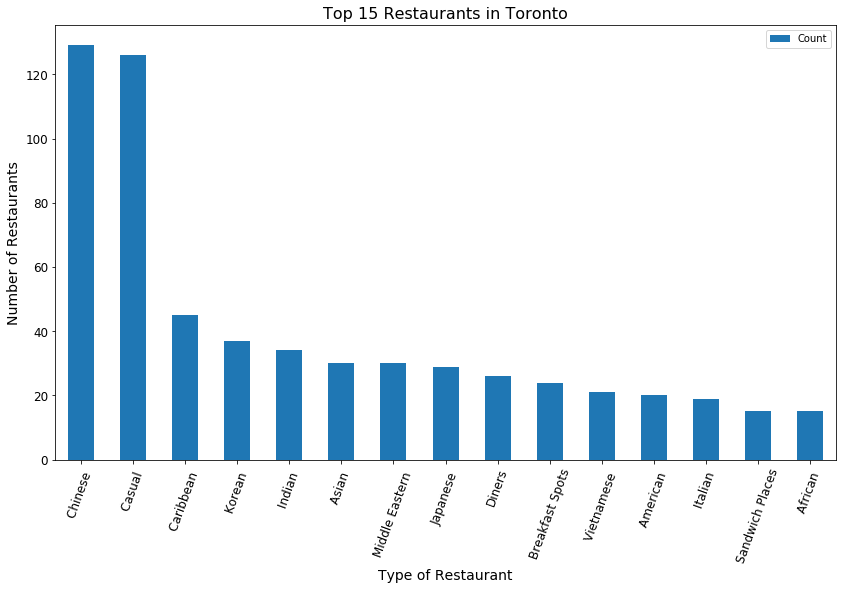

In [41]:
toronto_graph_df.set_index('Category', inplace = True)
ax = toronto_graph_df.plot(kind = 'bar', figsize = (14,8))

ax.set_title('Top 15 Restaurants in Toronto', size = 16)
ax.set_xlabel('Type of Restaurant', size = 14)
ax.set_ylabel('Number of Restaurants', size = 14)
                            
ax.tick_params(axis = 'x', which = 'major', labelsize = 12)
ax.tick_params(axis = 'y', which = 'major', labelsize = 12)

plt.xticks(rotation=70)

plt.show()

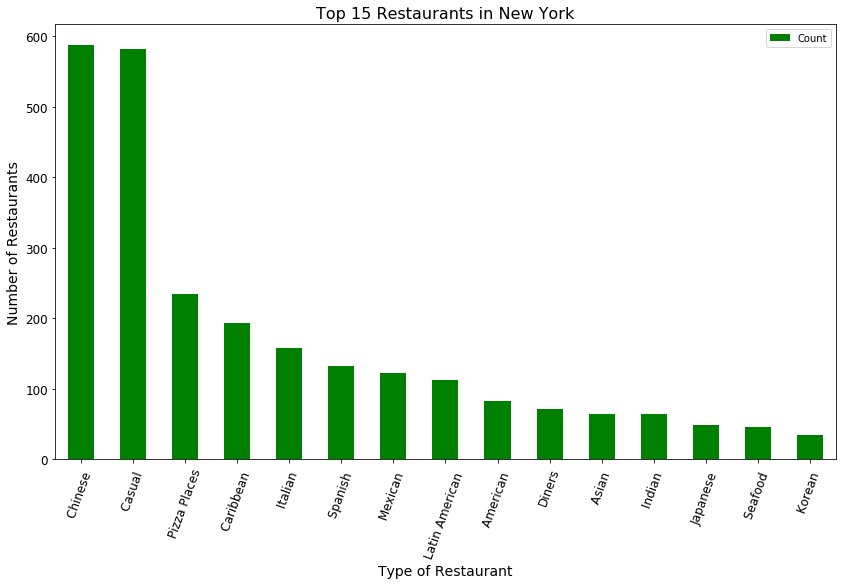

In [42]:
NYC_graph_df.set_index('Category', inplace = True)
ax = NYC_graph_df.plot(kind = 'bar', figsize = (14,8), color = 'green')

ax.set_title('Top 15 Restaurants in New York', size = 16)
ax.set_xlabel('Type of Restaurant', size = 14)
ax.set_ylabel('Number of Restaurants', size = 14)

ax.tick_params(axis = 'x', which = 'major', labelsize = 12)
ax.tick_params(axis = 'y', which = 'major', labelsize = 12)

plt.xticks(rotation=70)

plt.show()

  The graphs of both Toronto and New York show the major similarities and differences right away. Chinese restaurants are the most abundant restaurant category compared to other ethnic restaurants. Casual restaurants rank as second most popular for both cities as well. Starting from third place is where the real differences begin to show and present the different cultures of the cities. 